<a href="https://colab.research.google.com/github/remidion/PGM-Project/blob/main/Timeliness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/remidion/PGM-Project/blob/main/main.ipynb)

In [1]:
# Imports
from getpass import getpass
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
if os.path.exists('PGM-Project'):
  !git -C PGM-Project/ pull
else:
  u = input('GitHub username: ')
  p = getpass('GitHub password: ')
  !git clone https://$u:$p@github.com/remidion/PGM-Project.git
  del u, p

GitHub username: learicard
GitHub password: ··········
Cloning into 'PGM-Project'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 306 (delta 29), reused 15 (delta 2), pack-reused 243
Receiving objects: 100% (306/306), 32.61 MiB | 26.46 MiB/s, done.
Resolving deltas: 100% (178/178), done.


# Load Data

In [3]:
out_df = pd.read_csv("PGM-Project/data/route_01_inbound_full.csv", index_col=[0,1], header=[0,1])
out_df

scheduled           ... timeliness         
stop_sequence                          1.0      2.0  ...        8.0      9.0
service_date route_start_time                        ...                    
2018-08-02   1900-01-01 05:10:00   18600.0  18780.0  ...       Late  On Time
             1900-01-01 05:30:00   19800.0  19980.0  ...       Late     Late
             1900-01-01 05:50:00   21000.0  21180.0  ...       Late     Late
             1900-01-01 06:06:00   21960.0  22140.0  ...       Late     Late
             1900-01-01 06:21:00   22860.0  23040.0  ...    On Time  On Time
...                                    ...      ...  ...        ...      ...
2019-09-30   1900-01-01 23:40:00   85200.0  85380.0  ...    On Time  On Time
             1900-01-01 23:54:00   86040.0  86220.0  ...    On Time  On Time
             1900-01-02 00:22:00   87720.0  87900.0  ...      Early    Early
             1900-01-02 00:37:00   88620.0  88800.0  ...    On Time    Early
             1900-01-02 00:52:00   89520.0  89700.0  ...    On Time    Early

[37203 rows x 18 columns]

In [4]:
out2_df = pd.read_csv("PGM-Project/data/route_01_inbound_binned_30min_6a1h.csv", index_col=[0], header=[0,1])
nb_bins_2 = int(out2_df["route_bin"].nunique())
out2_df

service_date scheduled  ... timeliness            route_bin
stop_sequence Unnamed: 1_level_1       1.0  ...        9.0  Unnamed: 20_level_1
0                     2018-08-03   21960.0  ...    On Time  1900-01-01 06:00:00
1                     2018-08-03   23700.0  ...       Late  1900-01-01 06:30:00
2                     2018-08-03   25560.0  ...       Late  1900-01-01 07:00:00
3                     2018-08-03   27300.0  ...      Early  1900-01-01 07:30:00
4                     2018-08-03   28980.0  ...       Late  1900-01-01 08:00:00
...                          ...       ...  ...        ...                  ...
9153                  2019-09-30   81240.0  ...    On Time  1900-01-01 22:30:00
9154                  2019-09-30   83580.0  ...      Early  1900-01-01 23:00:00
9155                  2019-09-30   85200.0  ...    On Time  1900-01-01 23:30:00
9156                  2019-09-30   87720.0  ...      Early  1900-01-02 00:00:00
9157                  2019-09-30   88620.0  ...      Early  1900-01-02 00:30:00

[9158 rows x 20 columns]

In [5]:
out3_df = pd.read_csv("PGM-Project/data/route_01_inbound_binned_20min_7a18h.csv", index_col=[0], header=[0,1])
nb_bins_3 = int(out3_df["route_bin"].nunique())
out4_df = pd.read_csv("PGM-Project/data/route_01_inbound_binned_30min_7a18h.csv", index_col=[0], header=[0,1])
nb_bins_4 = int(out4_df["route_bin"].nunique())
out5_df = pd.read_csv("PGM-Project/data/route_01_outbound_binned_30min_7a18h.csv", index_col=[0], header=[0,1])
nb_bins_5 = int(out5_df["route_bin"].nunique())
out6_df = pd.read_csv("PGM-Project/data/route_01_outbound_binned_20min_7a18h.csv", index_col=[0], header=[0,1]) #To change to binned 20 minutes
nb_bins_6 = int(out6_df["route_bin"].nunique())

print(out3_df.shape,out4_df.shape,out5_df.shape,out6_df.shape)
print(nb_bins_3,nb_bins_4,nb_bins_5,nb_bins_6)
print(out3_df.shape[0]/33,out4_df.shape[0]/22,out5_df.shape[0]/22,out6_df.shape[0]/33)

(5181, 20) (5786, 20) (5236, 20) (2475, 20)
33 22 22 33
157.0 263.0 238.0 75.0


# Training

In [6]:
X = out_df['scheduled'].to_numpy()
y = out_df['timeliness'].to_numpy()

X2 = out2_df['scheduled'].to_numpy()
y2 = out2_df['timeliness'].to_numpy()

X3 = out3_df['scheduled'].to_numpy()
y3 = out3_df['timeliness'].to_numpy()

X4 = out4_df['scheduled'].to_numpy()
y4 = out4_df['timeliness'].to_numpy()

X5 = out5_df['scheduled'].to_numpy()
y5 = out5_df['timeliness'].to_numpy()

X6 = out6_df['scheduled'].to_numpy()
y6 = out6_df['timeliness'].to_numpy()

## Aligned Bins

In [7]:
# Split dataset into training set and test set
def split_ds(ds, split=0.2):
  X, y = ds
  split_idx = int(X.shape[0] * split)
  X_train, X_test, y_train, y_test = X[:-split_idx], X[-split_idx:], y[:-split_idx], y[-split_idx:]
  return X_train, X_test, y_train, y_test

In [8]:
def prep_df(X, y, n_bins):

  # Reshape into (Days x time bins x stops)
  shape = (X.shape[0]//n_bins, n_bins, X.shape[1])
  X = X.reshape(shape) 
  y = y.reshape(shape) 

  return [X, y]

In [9]:
#imported_data = [(X,y),(X2,y2),(X3,y3),(X4,y4),(X5,y5),(X6,y6)]
imported_data = [(X3,y3),(X4,y4),(X5,y5),(X6,y6)]
titles = ["route_01_inbound_binned_20min_7a18h","route_01_inbound_binned_30min_7a18h",
            "route_01_outbound_binned_30min_7a18h","route_01_outbound_binned_20min_7a18h"]
nb_bins = [nb_bins_3,nb_bins_4,nb_bins_5,nb_bins_6]

##Create train and test sets

In [10]:
X_tr = []
X_ts = []
y_tr = []
y_ts = []

for i,ds in enumerate(imported_data):
  xy_tup = prep_df(ds[0],ds[1],nb_bins[i])
  data = split_ds(xy_tup)
  X_tr.append(data[0])
  X_ts.append(data[1])
  y_tr.append(data[2])
  y_ts.append(data[3])
  print(i,X_tr[i].shape, nb_bins[i])

0 (126, 33, 9) 33
1 (211, 22, 9) 22
2 (191, 22, 9) 22
3 (60, 33, 9) 33


## Mode Baseline

In [11]:
from collections import Counter

def baseline(df, verbose=False):
  c = Counter(df.flatten())
  counts = np.array(list(c.values()))
  if verbose: print('Values: ', dict(c.items()))
  ratio = counts/sum(counts)
  mode_performance = max(ratio)
  if verbose: print('Distribution: ', ratio)
  return mode_performance

def b2(df, verbose=False):
  c = Counter(df.flatten())
  myDict = dict(c.items())
  
  s = sum(c.values())
  key = max(myDict, key=myDict.get)
  if verbose: 
    print(myDict)
    baseline = f'{myDict[key]/s} for "{key}"'
  else:
    baseline = myDict[key]/s
  #print(key, myDict[key]/s)
  return baseline

#print(' y:', b2(y))
#print()
#print('y2:', b2(y2))
#print()

for i,y in enumerate(y_tr):
  print(f'y{i+1}: {b2(y, True)}')
  print()

{'On Time': 18789, 'Late': 11015, 'Early': 7618}
y1: 0.5020843354176687 for "On Time"

{'On Time': 20140, 'Late': 13101, 'Early': 8537}
y2: 0.48207190387285176 for "On Time"

{'On Time': 16314, 'Late': 17977, 'Early': 3527}
y3: 0.4753556507483209 for "Late"

{'On Time': 8036, 'Late': 7871, 'Early': 1913}
y4: 0.45095398428731764 for "On Time"



# Inference

##Tentative code

In [12]:
def get_dtw(knots, x, homogenous=False):
  if homogenous: return 0
  for k in range(len(knots) - 1):
        if x >= knots[k] and x < knots[k + 1]:
            return k

def parametrization_2d(state_dict, X_tr, y_tr, knots=None, h_vect=None, dimension=0):

  if h_vect is None: 
    h_vect = [True, True, True, True]
    print('h_vect created')
  HP = h_vect[0]
  HQ = h_vect[1]
  HTP = h_vect[2]
  HTQ = h_vect[3]


  D, S, T = X_tr.shape

  # Initialize the Transition Matrix.ces
  KP = 1 if HTP else len(knots)-1
  KQ = 1 if HTQ else len(knots)-1
  LP = 1 if HP else T-1
  LQ = 1 if HQ else T
  
  
  P = np.zeros((LP,KP,3,3))
  Q = np.zeros((LQ,KQ,3,3))
  pi_h = np.zeros((KP, 3))
  pi_v = np.zeros((LQ, 3))

  #update
  for i in range(D):
    for s in range(S):
      for j in range(T):
        actual_state = state_dict[y_tr[i,s,j]]
        dtwP = get_dtw(knots, X_tr[i,s,j], HTP)
        dtwQ = get_dtw(knots, X_tr[i,s,j], HTQ)

        # Update pi s
        if j == 0:
          pi_h[dtwP, actual_state] += 1
        
        if s == 0:
          l = 0 if HQ else j
          pi_v[l, actual_state] += 1

        # Update P
        if j < T - 1:
          next_state = state_dict[y_tr[i, s,  j + 1]]
          l = 0 if HP else j
          P[l, dtwP, actual_state, next_state] +=  1

        #Update Q
        condition = (s<S-1) if dimension == 0 else (i<D-1)
        
        if condition:
          if dimension == 0:
            next_state = state_dict[y_tr[i, s + 1, j]]
          else: 
            next_state = state_dict[y_tr[i + 1, s, j]]
          l = 0 if HQ else j
          Q[l, dtwQ, actual_state, next_state] +=  1

  #normalize
  for l in range(LQ):  
    if sum(pi_v[l,:]) == 0:
      pi_v[l,:] = [0,1,0]  # Default is "On Time"
      #pi[k,:] = [1/3, 1/3, 1/3]
    else:
      pi_v[l,:] = pi_v[l,:] / sum(pi_v[l,:])
    
    for k in range(KQ):
      for r in range(3):
        if Q[l,k,r,:].sum() == 0: Q[l,k,r,:] = pi_v[l,:] #[1/3, 1/3, 1/3]            
      Q[l,k,:,:] = (Q[l,k,:,:].T/Q[l,k,:,:].sum(axis = 1)).T
  
  for k in range(KP):
    if sum(pi_h[k,:]) == 0:
      pi_h[k,:] = [0,1,0]  # Default is "On Time"
      #pi[k,:] = [1/3, 1/3, 1/3]
    else:
      pi_h[k,:] = pi_h[k,:] / sum(pi_h[k,:])

    for j in range(LP):
      for r in range(3):
        if P[j,k,r,:].sum() == 0: P[j,k,r,:] = pi_h[k,:] #[1/3, 1/3, 1/3]
      P[j,k,:,:] = (P[j,k,:,:].T/P[j,k,:,:].sum(axis = 1)).T

  return pi_h, pi_v, P, Q

def pred_stop(state_dict, pi_h, pi_v, s, P, Q, time_stamp, knots = None, h_vect = None, alpha=1, previous_sequence = None, current_sequence=None):
  #x(t+1, h+1) = alpha * x(t, h+1) * P + (1 - alpha) * x(t+1, h) * Q
  if h_vect is None: h_vect = [True, True, True]
  HP = h_vect[0]
  HQ = h_vect[1]
  HTP = h_vect[2]
  HTQ = h_vect[3]

  T = time_stamp.shape[0]
  next_state = []

  for t in range(T):
    dtwP = get_dtw(knots, time_stamp[t], HTP)
    dtwQ = get_dtw(knots, time_stamp[t], HTQ)

    #horizontal
    if t==0:
      horizontal = pi_h[dtwP, :]
    else:
      if current_sequence is None:
        current_state = state_dict[next_state[t-1]]
      else:
        current_state = state_dict[current_sequence[t-1]]
      l = 0 if HP else t-1
      horizontal = P[l, dtwP, current_state, :]
    
    #vertical
    l = 0 if HQ else t
    if s == 0: 
      vertical = pi_v[l, :] 
    else:
      vertical = Q[l, dtwQ, state_dict[previous_sequence[t]], :]

    idx = np.argmax(alpha * horizontal + (1-alpha) * vertical)
    next_state.append(list(state_dict.keys())[idx])

  return next_state

In [13]:
KNOTS = [[0, 21600, 32400, 50400, 64800, 93600], [3600*i for i in range(0, 26 + 1)]]
state_dict = {'Early': 0, 'On Time': 1, 'Late': 2}

def h2vect(h):
  ## homogenous  = 0 : all homogenous
  ## homogenous  = 1 : all homogeneous except Q stop
  ## homogenous  = 2 : all homogeneous except P stop
  ## homogenous  = 3 : all homogeneous except P & Q stop
  ## homogenous  = 4 : all homogeneous except time Q
  ## homogenous  = 5 : all homogeneous except time Q and stop Q
  ## homogenous  = 6 : all homogeneous except time Q and stop P
  ## homogenous  = 7 : all inhomogeneous except time P
  ## homogenous  = 8 : all homogeneous except time P
  ## homogenous  = 9 : all homogeneous except time P and stop Q
  ## homogenous  = 10 : all homogeneous except time P and stop P
  ## homogenous  = 11 : all inhomogeneous except time Q
  ## homogenous  = 12 : all homogeneous except time P & Q
  ## homogenous  = 13 : all inhomogeneous except stop P
  ## homogenous  = 14 : all inhomogeneous except stop Q
  ## homogenous  = 15 : all inhomogeneous
  P_time_homogenous = (h in [0,1,2,3,4,5,6,7])  
  Q_time_homogenous = (h in [0,1,2,3,8,9,10,11])  
  P_stop_homogenous = (h in [0,1,4,5,8,9,12,13])
  Q_stop_homogenous = (h in [0,2,4,6,8,10,12,14])

  h_vect = [P_stop_homogenous, Q_stop_homogenous, P_time_homogenous, Q_time_homogenous] 
  return h_vect

In [14]:
def experiment(data, hyperparams, test = False, verbose=True):

  train_trips = data[0]  # Unordered list of bus TRIPS - May be empty
  train_timeliness = data[1]  # Associated state labels ^ - May be empty

  if verbose: print('last continuous-time timestamp:', np.max(train_trips)/3600)

  #----- Parameters ----- 
  if verbose: print('==== Hyperparameters ====')
  homogenous  = hyperparams[0]
  if verbose: print('Homogenous =',homogenous)
  h_vect = h2vect(homogenous)

  if verbose: print('P Stop Homogenous =',P_stop_homogenous)
  if verbose: print('Q Stop Homogenous =',Q_stop_homogenous)
  if verbose: print('P Time Homogenous =',P_time_homogenous)
  if verbose: print('Q Time Homogenous =',Q_time_homogenous)

  ### DTWs time limits (for inhomogenous chains) ###
  #[0...3600*H] where H = 26  => There are 26 "workable" hours for a bus trip
  inhomogenous_method = hyperparams[1]
  if verbose: print('Inhomogenous Method =', inhomogenous_method)
  knots = KNOTS[inhomogenous_method]

  direction = hyperparams[2]
  ## direction = 0 : horizontal
  ## direction = 1 : vertical
  ## direction = 2 : 2D
  if verbose: print('Conditional Dependance Direction =', direction)

  ## 2D combination factor x(t+1, h+1) = alpha * x(t, h+1) * P + (1 - alpha) * x(t+1, h) * Q
  ## where 
  ##   t is the stop ID
  ##   h is the hour of the day
  ##   P is the horizontal transition matrix (stop_id-wise)
  ##   Q is the vertical transition matrix (time-wise)
  if direction == 0:
    alpha = 1
  elif direction == 1:
    alpha = 0
  elif direction == 2:
    alpha = hyperparams[3]  # Any value between 0 and 1
    if alpha < 0 or alpha > 1:
      raise Exception('alpha must be between 0 and 1')
  if verbose: print('alpha =', alpha)
  
  gamma = hyperparams[4]  # damping coefficient
  if verbose: print('gamma = ', gamma)
  if verbose: print('validation split = ', valid_split)

  slidewindow_len = hyperparams[5]  # Nb of previous days considered: 60
  if verbose: print('Sliding Window Size (days) = ', slidewindow_len)

  dimension = hyperparams[6]  # Which sequence is taken (0:previous trip, or 1:previous day)
  if verbose: print('Dimension = ', dimension)

  pre_trained_params = hyperparams[7]
  pi_h_batch, pi_v_batch, P_batch, Q_batch = pre_trained_params
  #----------------------

  #------- Reshape  ------- 
  D, S, T = train_trips.shape  # (Day, hour-of-the-day, bus-stop-ID)
  x_seq = train_trips
  y_seq = train_timeliness

  #------- Split Dataset ------- 
  #split_idx = int(train_trips.shape[0] * valid_split)
  #x_tr, x_seq = train_trips[:-split_idx], train_trips[-split_idx:]
  #y_tr, y_seq = train_timeliness[:-split_idx], train_timeliness[-split_idx:]

  D, S, T = x_seq.shape  # (Days, time step, bus-stop-ID)

  if verbose:
    print('==== Dataset ====')
    print(f'X: Timestamp of scheduled bus stop, Y: Timeliness on that day at that bus stop')
    print(x_seq.shape, y_seq.shape)

  #-- Check clean Data --
  if x_seq.shape[0] == 0: 
    #raise Exception('Empty validation set, increase "valid_split"')
    print('Empty validation set, increase "valid_split"')
 
  #----------------------


  #Init
  accu1 = 0
  accu2 = 0

  if test: 
    v_actual_states = np.empty([D - slidewindow_len,S,T], dtype = 'S10')
    v_pred_states = np.empty([D - slidewindow_len,S,T], dtype = 'S10')
    h_actual_states = np.empty([D - slidewindow_len,S,T], dtype = 'S10')
    h_pred_states = np.empty([D - slidewindow_len,S,T], dtype = 'S10')

  for i in range(slidewindow_len, D):
    # Create a validation set   
    X_seq = x_seq[i-slidewindow_len:i,:,:]
    Y_seq = y_seq[i-slidewindow_len:i,:,:]

    # Train
    pi_h, pi_v, P, Q = parametrization_2d(state_dict, X_seq, Y_seq, knots, h_vect, dimension)
    pi_h = gamma * pi_h + (1-gamma) * pi_h_batch
    pi_v = gamma * pi_v + (1-gamma) * pi_v_batch
    P = gamma * P + (1-gamma) * P_batch
    Q = gamma * Q + (1-gamma) * Q_batch
    
    for s in range(S):
      
      X_tst = x_seq[i,s,:]
      Y_tst = y_seq[i,s,:]
  
      #Predict the complete sequence of states for the following trip given a trip
      if dimension == 0:
        previous_sequence = y_seq[i,s - 1,:] if s > 0 else None
      else:
        previous_sequence = y_seq[i - 1,s,:] if s > 0 else None
      future_states = pred_stop(state_dict, pi_h, pi_v, s, P, Q, X_tst, knots, h_vect, alpha, previous_sequence)
      if test:
        v_pred_states[i - slidewindow_len,s,:] = future_states
        v_actual_states[i - slidewindow_len,s,:] = Y_tst
      for t in range(T):
        if Y_tst[t] == future_states[t]:
          accu1 += 1

      #Predict the state of the next stop given the previous trip and the state of the current stop
      future_states = pred_stop(state_dict, pi_h, pi_v, s, P, Q, X_tst, knots, h_vect, alpha, previous_sequence, Y_tst)
      if test:
        h_pred_states[i - slidewindow_len,s,:] = future_states
        h_actual_states[i - slidewindow_len,s,:] = Y_tst
      for t in range(T):
          if Y_tst[t] == future_states[t]:
            accu2 += 1

      if i%100==0: print(f'accu1: {accu1}, accu2: {accu2}', end='\r')


  accu1 = accu1 /((D  - slidewindow_len) * S * T)
  accu2 = accu2 /((D - slidewindow_len) * S * T)
  if verbose:
    print('==== Results ====')
    print('Next Sequence:', accu1)
    print('Next State', accu2)
    print()
    print()
  if test:
    return accu1, accu2, v_pred_states, v_actual_states, h_pred_states, h_actual_states 
  else:
    return accu1, accu2

In [57]:
from datetime import datetime as dt

def test(dataset):
  #Test over all datasets
  [X_ts, y_ts] = dataset


  #========= Configuration ===========
  # Set Hyperparemeters
  homogenous = 5           # 0-15
  inhomogenous_method = 1   # 0:Peak periods, 1:Hourly
  direction = 1             # 0:Horizontal, 1:Vertical, 2:2D
  alpha = 1               # [0,0.5]:vertical (time) axis dominates, [0.5,1]:horizontal (stop_id) axis dominates
  gamma = 0.7               # [0,0.5]:static set of routes dominate, [0.5,1]:set of recent routes dominates
  slidewindow_len = 30      # Nb of days from which the priors and transition matrix are computed
  dimension = 1             # Q depends on 0: previous trip, 1: same trip from previous day

  knots = KNOTS[inhomogenous_method]

  print('hyperparams = [homogenous, inhomogenous_method, direction, alpha, training_method, gamma, valid_split, slidewindow_len, dimension]')
  print('hyperparams,              Sequence Prediction, State Prediction, baseline, nb_bins')

  fname = dt.now().strftime("%y%m%d_%H%M%S")
  with open(f'PGM-Project/data/results_{fname}.txt', "w") as myfile:
    myfile.write('hyperparams, Sequence Prediction, State Prediction, baseline, nb_bins\n')


  for ds_i in range(len(titles)):
    Xparam = X_tr[ds_i]
    yparam = y_tr[ds_i]

    Xtest = X_ts[ds_i]
    ytest = y_ts[ds_i]

    param_data = [Xparam, yparam] 
    xv = np.vstack((Xparam[-(slidewindow_len-1):],Xtest))
    yv = np.vstack((yparam[-(slidewindow_len-1):],ytest))
    data = [xv, yv]  

    pre_trained_params = parametrization_2d(state_dict, Xparam, yparam, knots, h2vect(homogenous), dimension)
    hyperparams = [homogenous, inhomogenous_method, direction, alpha, gamma, slidewindow_len, dimension, pre_trained_params]

    accu1, accu2, v_pred_states, v_actual_states, h_pred_states, h_actual_states  = experiment(data, hyperparams, test = True, verbose=False)
    print(h_pred_states.shape)
    for i in range(h_pred_states.shape[2]):
      fig1, ax1 = plt.subplots(figsize=(10,4))
      ax1.plot(np.arange(-3,h_actual_states[10,:,i].shape[0]), np.append(['Early', 'On Time', 'Late'] , h_actual_states[10,:,i]), color = 'k')
      ax1.plot(np.arange(-3,h_pred_states[10,:,i].shape[0]),np.append(['Early', 'On Time', 'Late'] , h_pred_states[10,:,i]), "--", color = "b")
      ax1.set_xlim(0)
      ax1.set_xlabel('Departure bin')
      ax1.set_ylabel('State')
      ax1.legend(['Observed state', 'Predicted state'], loc = 1)
      fig1.savefig('PGM-Project/plots/plot_horizontal_' + titles[ds_i] + '_stop' + str(i) + '.png' ,bbox_inches='tight', facecolor='white')
      
      fig2, ax2 = plt.subplots(figsize=(10,4)) 
      ax2.plot(np.arange(-3,v_actual_states[10,:,i].shape[0]),  np.append(['Early', 'On Time', 'Late'] , v_actual_states[10,:,i]), color = 'k')
      ax2.plot(np.arange(-3,v_pred_states[10,:,i].shape[0]),  np.append(['Early', 'On Time', 'Late'] , v_pred_states[10,:,i]), "--", color = "b" )
      ax2.set_xlim(0)
      ax2.set_xlabel('Departure bin')
      ax2.set_ylabel('State')
      ax2.legend(['Observed state', 'Predicted state'], loc = 1)
      fig2.savefig('PGM-Project/plots/plot_vertical_' + titles[ds_i] + '_stop' + str(i) + '.png' ,bbox_inches='tight', facecolor='white')

    print(f"{titles[ds_i]}, {hyperparams[:-1]}, {accu1:.4f}, {accu2:.4f}, {b2(yparam):.4f}, {nb_bins[ds_i]}")
    with open(f'PGM-Project/data/test_results_{fname}.txt', "a") as myfile:
      myfile.write(f"{titles[ds_i]}, {hyperparams[:-1]}, {accu1}, {accu2}, {b2(yparam)}, {nb_bins[ds_i]}\n")
    

hyperparams = [homogenous, inhomogenous_method, direction, alpha, training_method, gamma, valid_split, slidewindow_len, dimension]
hyperparams,              Sequence Prediction, State Prediction, baseline, nb_bins
(30, 33, 9)
route_01_inbound_binned_20min_7a18h, [5, 1, 1, 1, 0.7, 30, 1], 0.5791, 0.5791, 0.5021, 33
(51, 22, 9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

route_01_inbound_binned_30min_7a18h, [5, 1, 1, 1, 0.7, 30, 1], 0.5735, 0.5735, 0.4821, 22
(46, 22, 9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

route_01_outbound_binned_30min_7a18h, [5, 1, 1, 1, 0.7, 30, 1], 0.6241, 0.6241, 0.4754, 22
(14, 33, 9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

route_01_outbound_binned_20min_7a18h, [5, 1, 1, 1, 0.7, 30, 1], 0.5806, 0.5806, 0.4510, 33


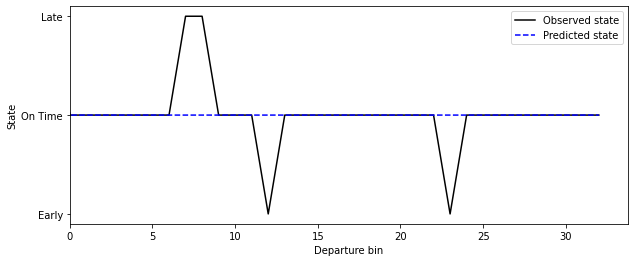

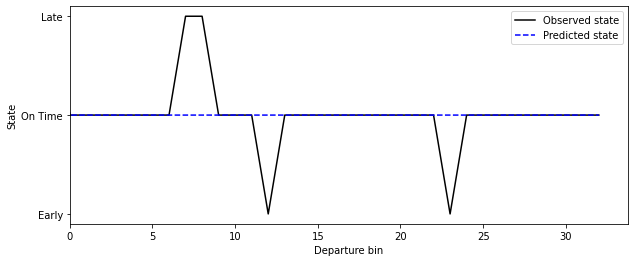

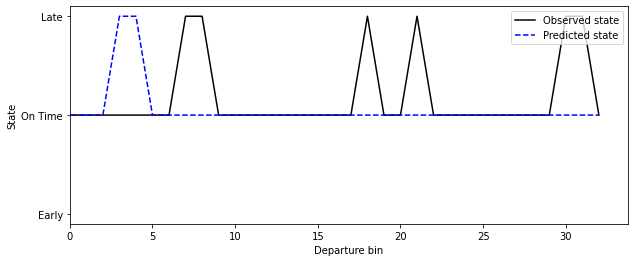

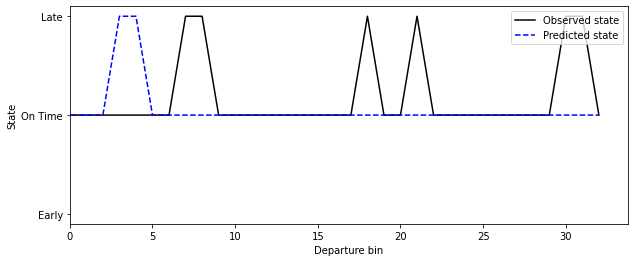

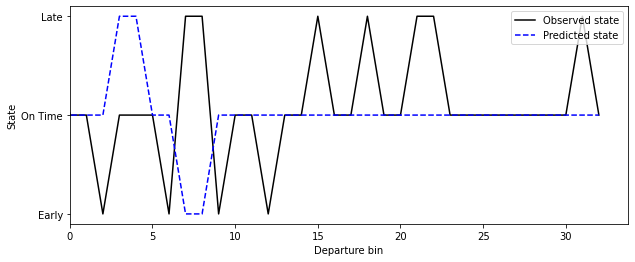

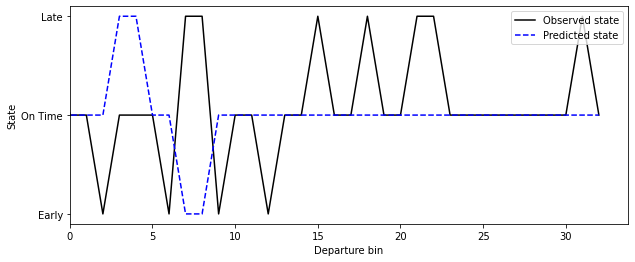

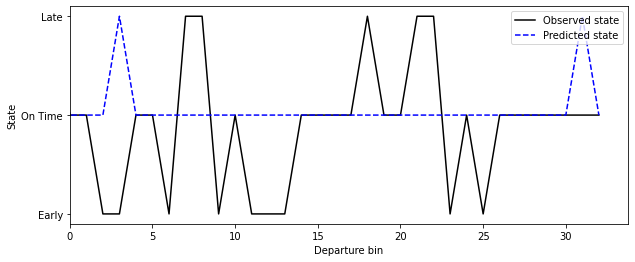

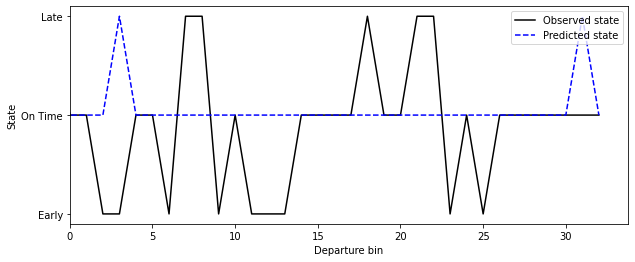

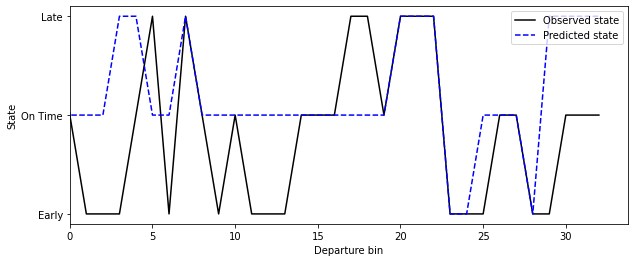

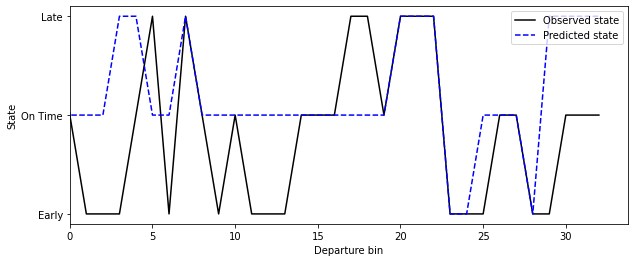

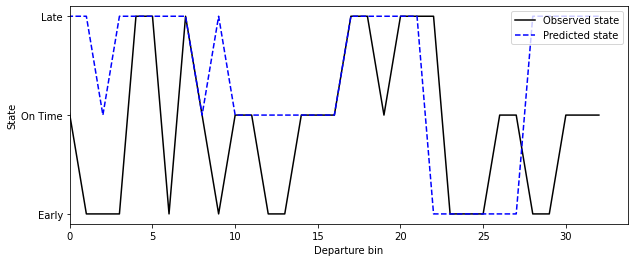

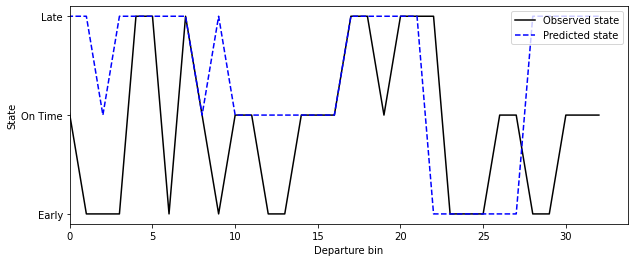

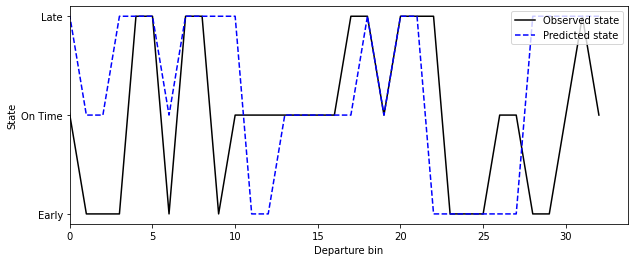

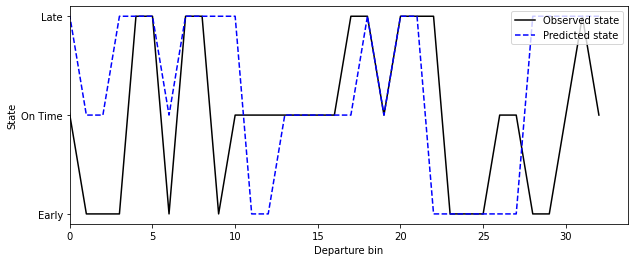

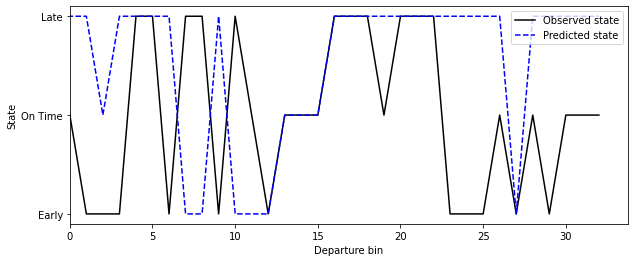

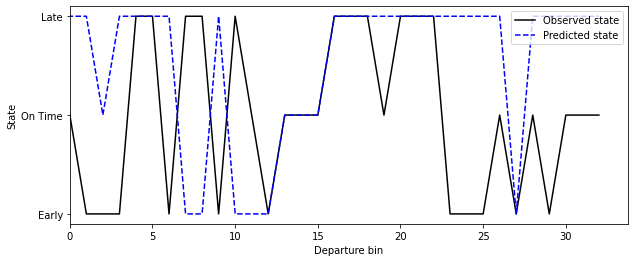

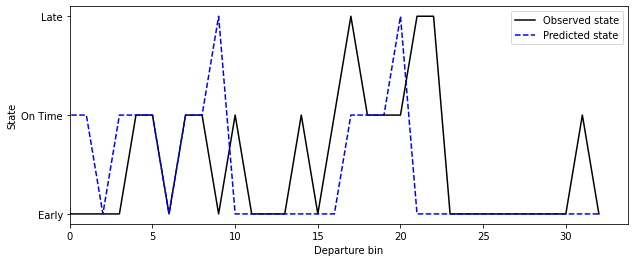

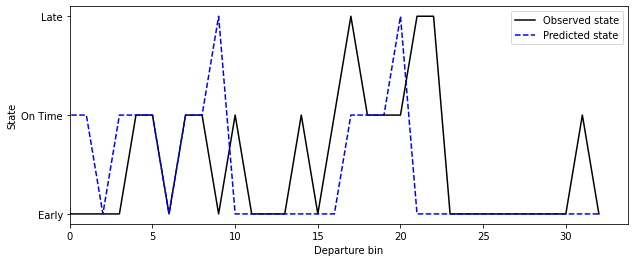

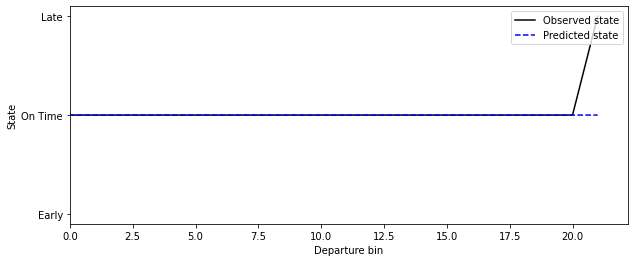

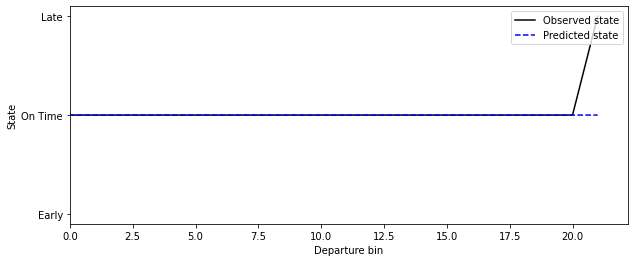

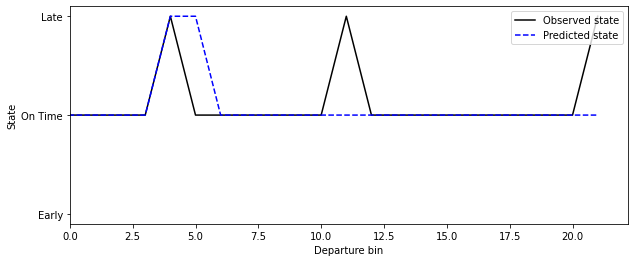

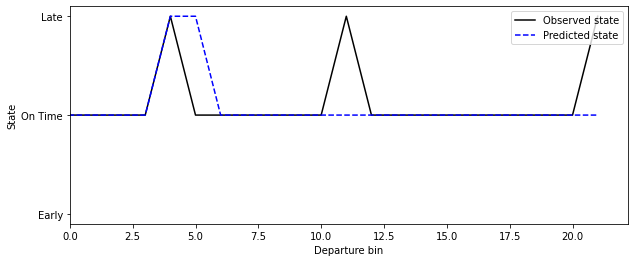

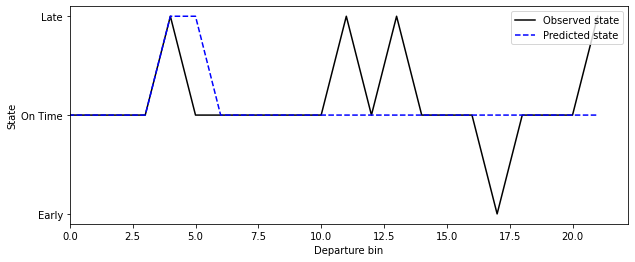

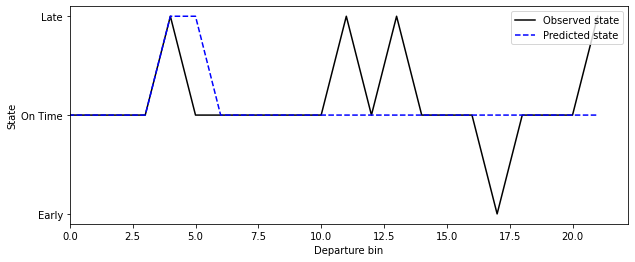

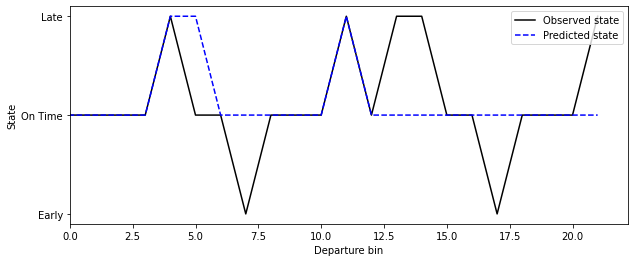

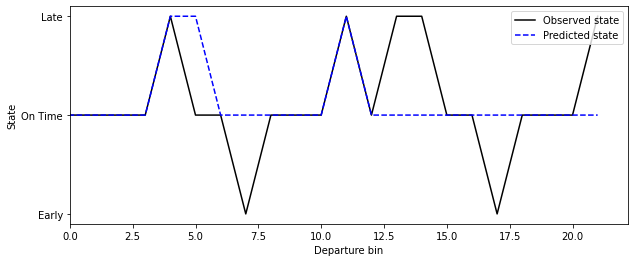

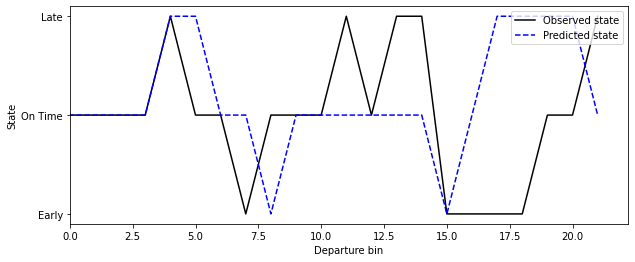

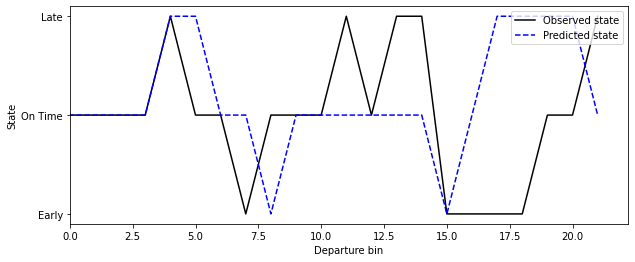

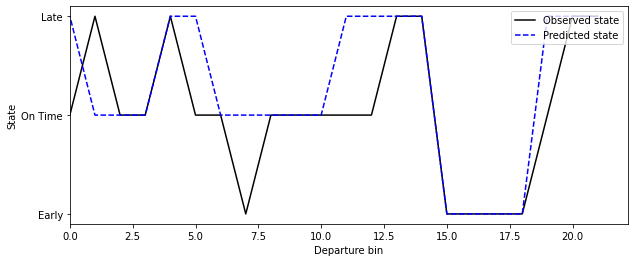

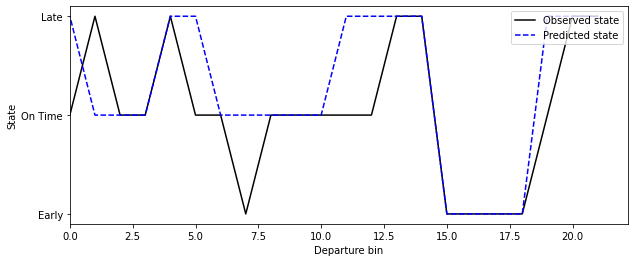

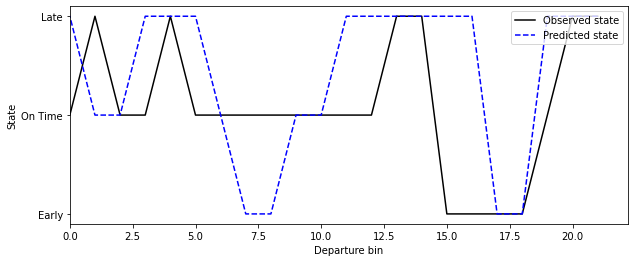

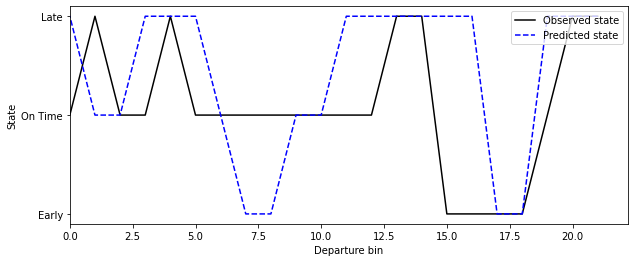

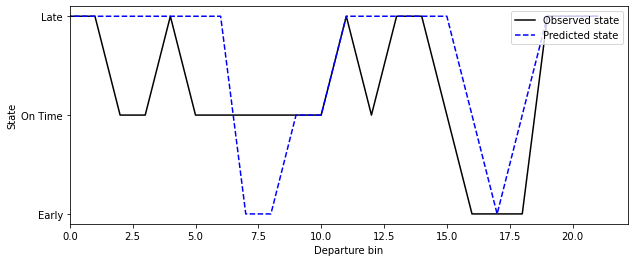

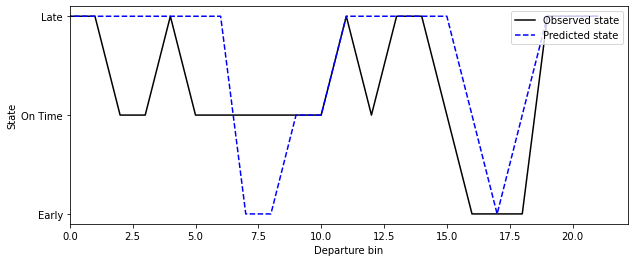

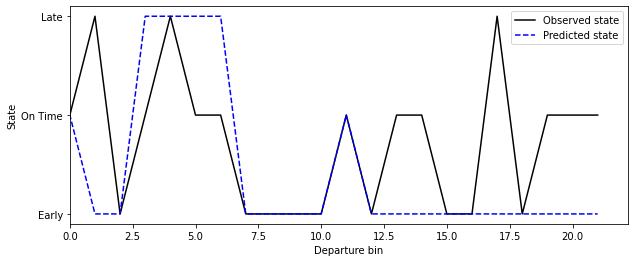

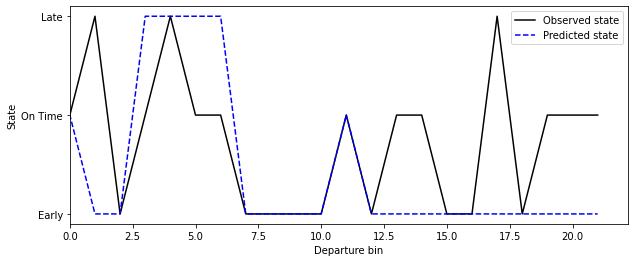

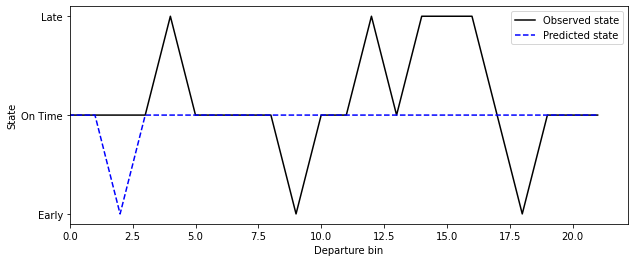

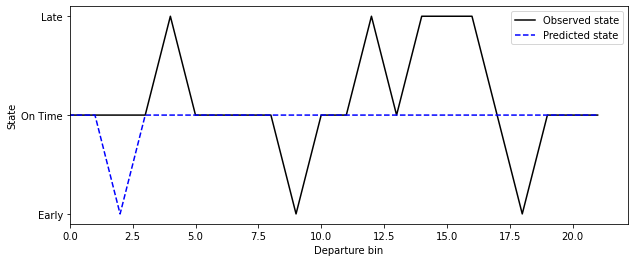

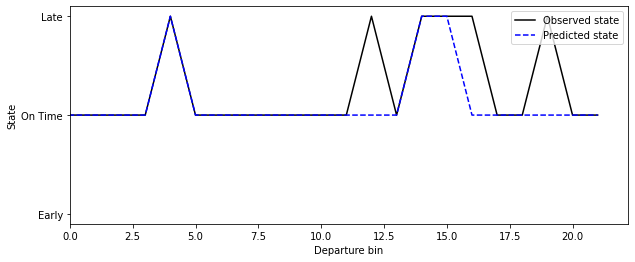

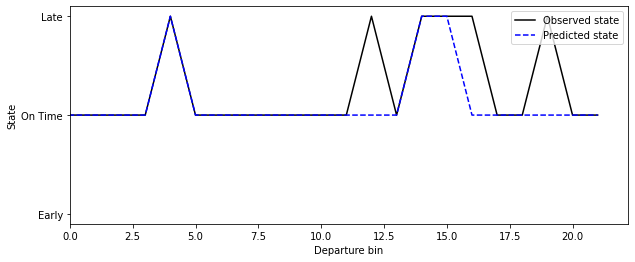

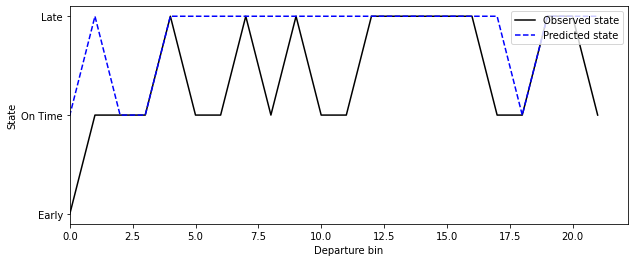

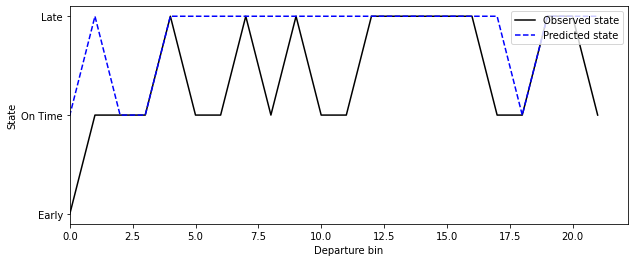

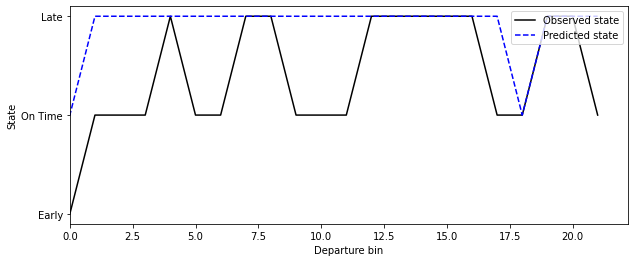

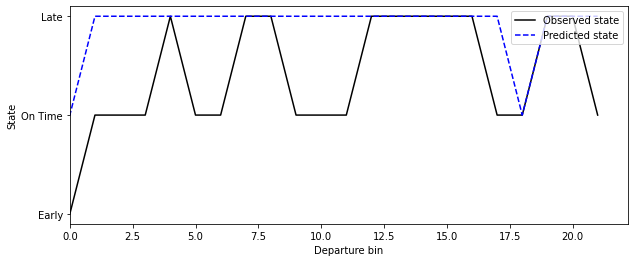

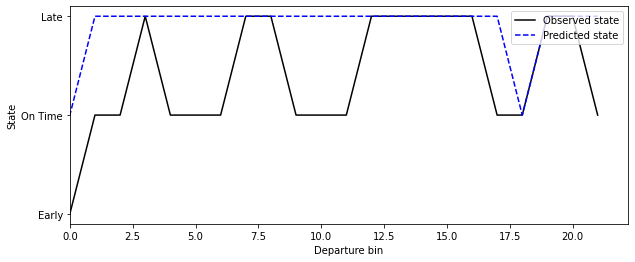

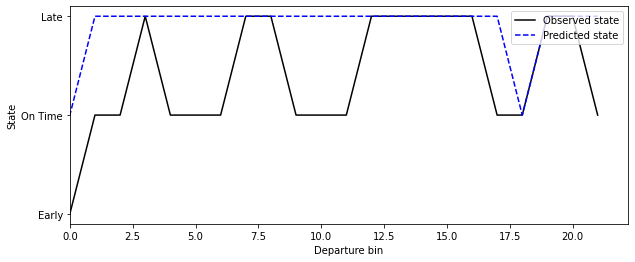

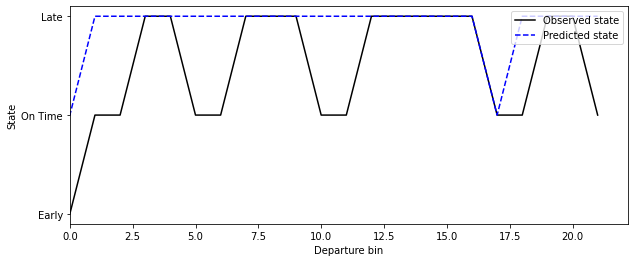

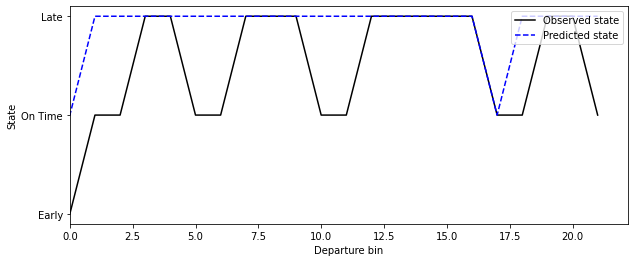

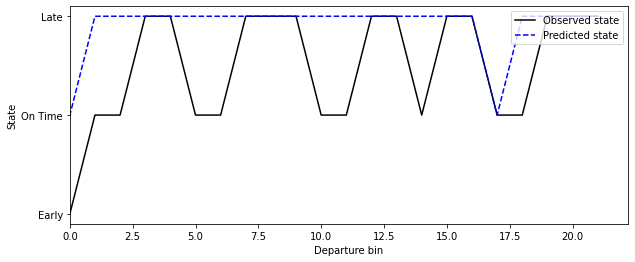

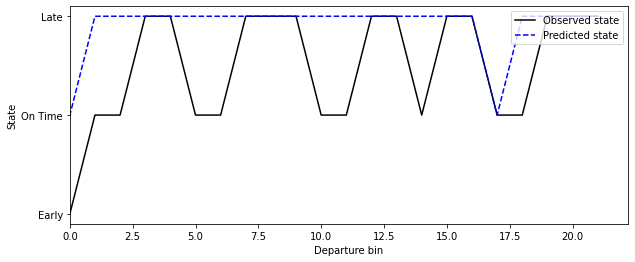

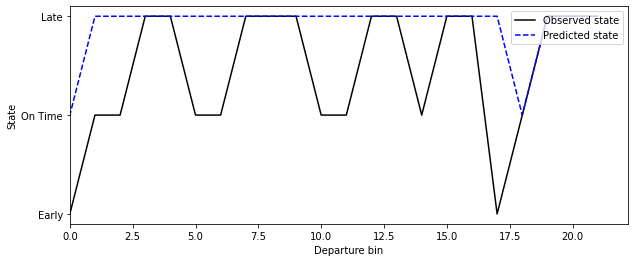

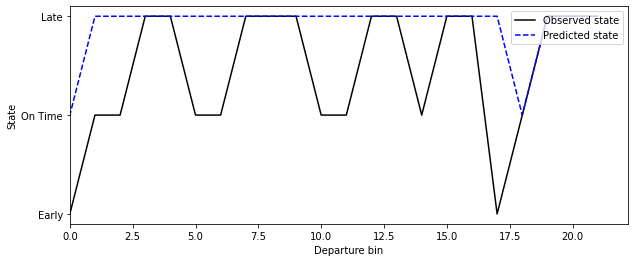

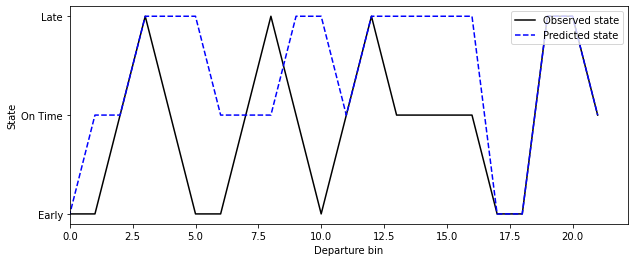

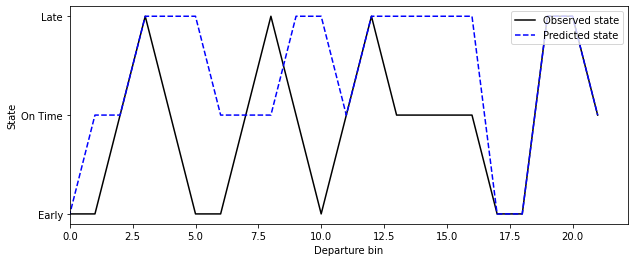

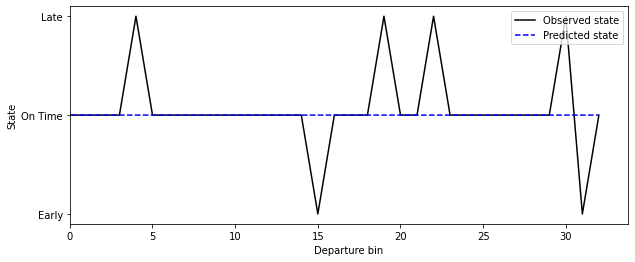

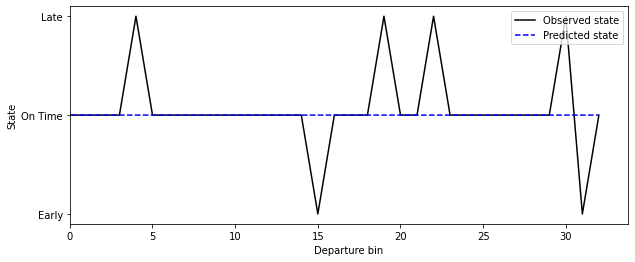

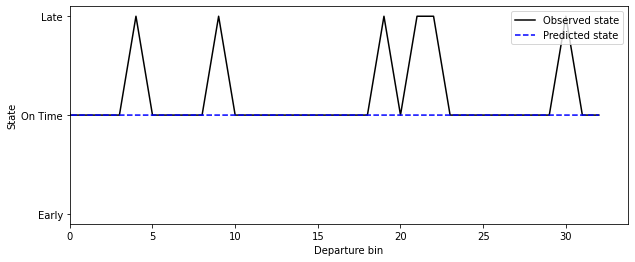

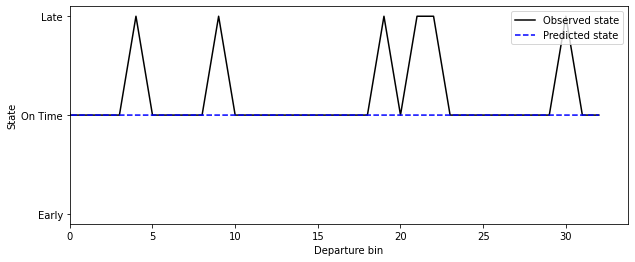

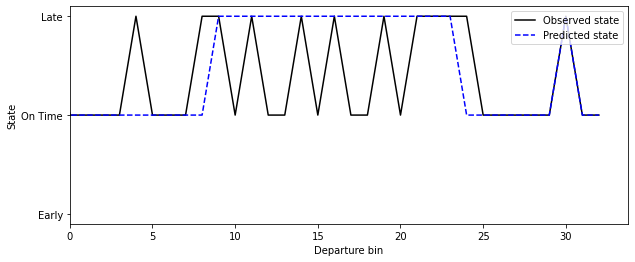

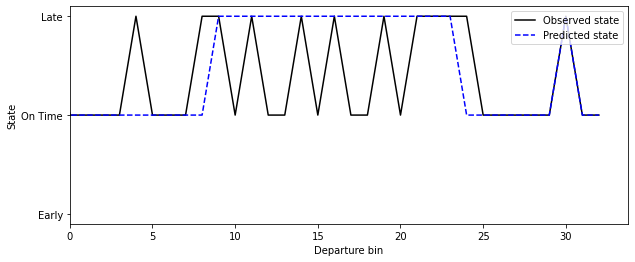

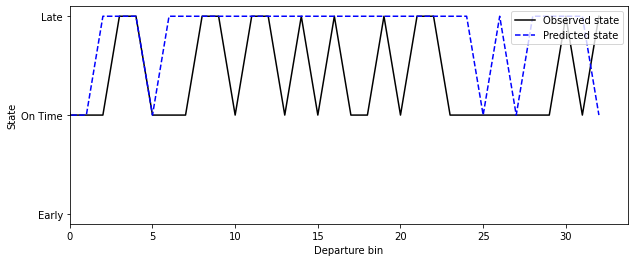

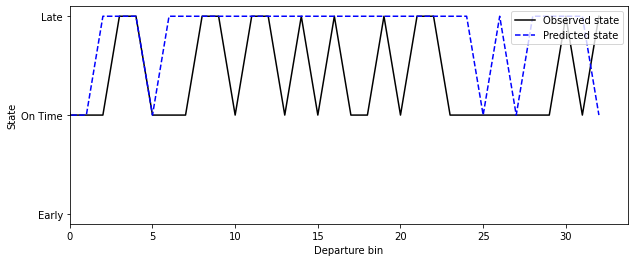

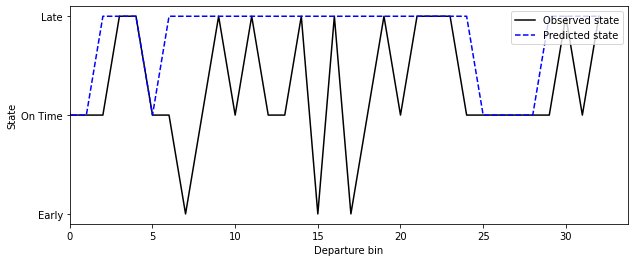

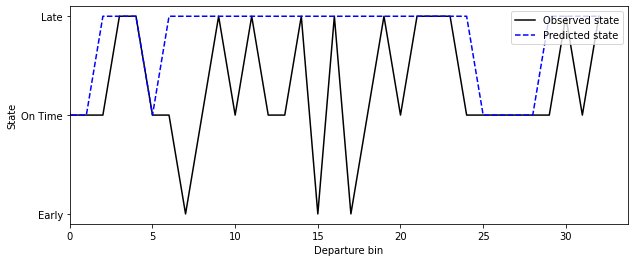

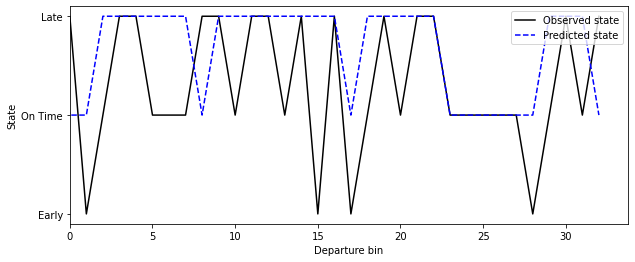

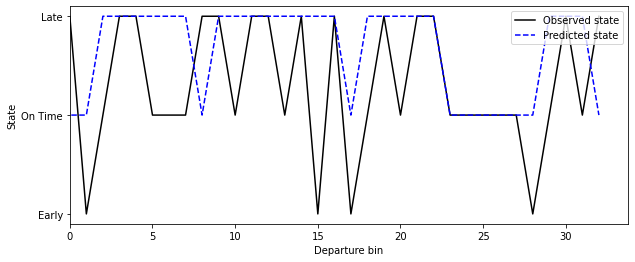

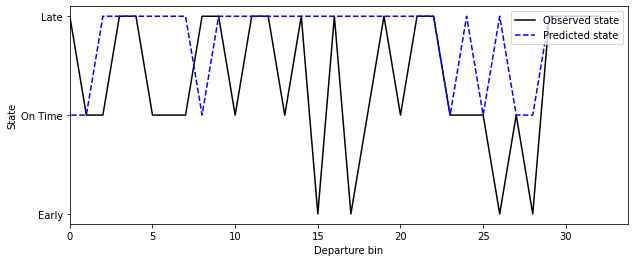

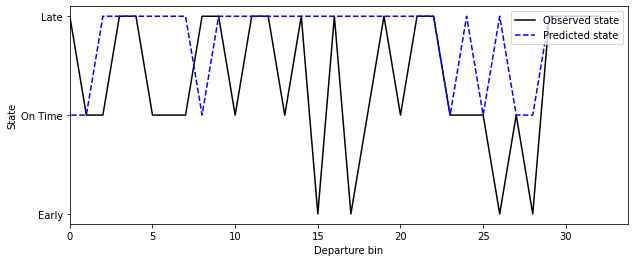

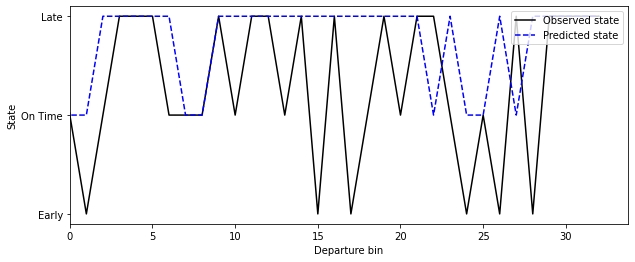

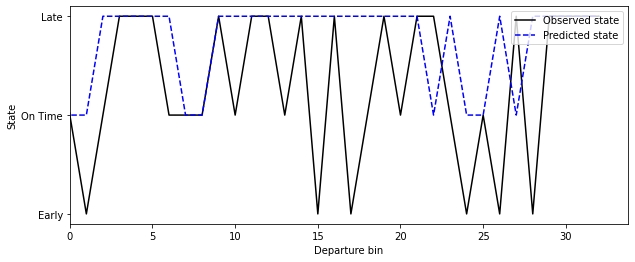

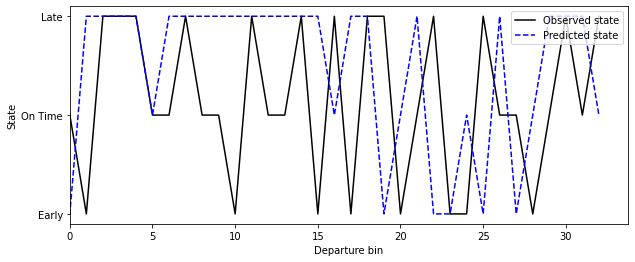

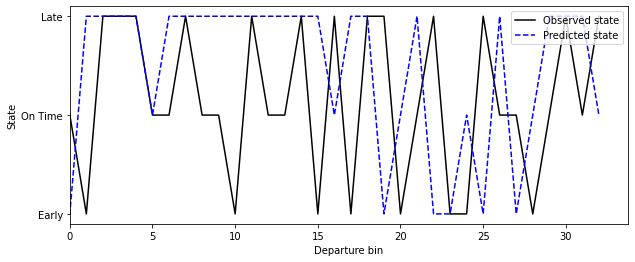

In [58]:
test_data = [X_ts, y_ts]
test(test_data)

In [ ]:
def train(dataset):
  # train over all parameters
  
  title = dataset[0]
  pre_tr = dataset[1][0]
  val = dataset[1][1]
  nb_bins = dataset[2]

  Xparam = pre_tr[0]
  yparam = pre_tr[1]
  
  Xval = val[0]
  yval = val[1]
  
  idx = 0
  for dimension in [0,1]:
    for direction in [0,1,2]:
      if   direction == 0: HOMOGEN = [0,2,8,10]
      elif direction == 1: HOMOGEN = [0,1,4,5]
      elif direction == 2: HOMOGEN = range(16)
      for homogenous in HOMOGEN:
        for inhomogenous_method in [0,1]:
          for slidewindow_len in [60, 30, 10, 5]:
            if Xval.shape[0] < slidewindow_len:
              real_window = Xval.shape[0]-10
              print(f'Sliding Window reduced to: {slidewindow_len} days')
            else: 
              real_window = slidewindow_len
            param_data = [Xparam, yparam] 
            xv = np.vstack((Xparam[-(slidewindow_len-1):],Xval))
            yv = np.vstack((yparam[-(slidewindow_len-1):],yval))
            data = [xv, yv] 

            knots = KNOTS[inhomogenous_method]
            pre_trained_params = parametrization_2d(state_dict, Xparam, yparam, knots, h2vect(homogenous), dimension)
            if direction == 2: ALPHA = [.1,.3,.5,.7,.9]
            else: ALPHA = [direction]
            for alpha in ALPHA:
              GAMMA = [.5, .7, .9, 1]
              for gamma in GAMMA:

                hyperparams = [homogenous, inhomogenous_method, direction, alpha, gamma, real_window, dimension, pre_trained_params]
                accu1, accu2 = experiment(data, hyperparams, verbose=False)
                idx += 1
                print(f"{title}, {idx:>10}, {f'{hyperparams[:-1]}':>30}, {accu1:.4f}, {accu2:.4f},{b2(yparam):.4f}, {nb_bins}")
                with open(f'PGM-Project/data/train_results_{fname}.txt', "a") as myfile:
                  myfile.write(f"{title}, {idx:>10}, {f'{hyperparams[:-1]}':>30}, {accu1}, {accu2},{b2(yparam)}, {nb_bins}\n")



In [ ]:
from datetime import datetime as dt

#train 
hyp = 'hyperparams = [homogenous, inhomogenous_method, direction, alpha, gamma, slidewindow_len, dimension]'
print(hyp)
print('hyperparams,              Sequence Prediction, State Prediction, Baseline, nb_bins')

fname = dt.now().strftime("%y%m%d_%H%M%S")
with open(f'PGM-Project/data/results_{fname}.txt', "w") as myfile:
  myfile.write(f'{hyp}\n Hyperparams, Sequence Prediction, State Prediction, Baseline, nb_bins\n')

X_pre_tr = []
X_val = []
y_pre_tr = []
y_val = []

# split train into pre-train and validation sets (0.5 split)
for i in range(len(titles)):
  
  ds = [X_tr[i], y_tr[i]]
  data = split_ds(ds, split=0.5)

  X_pre_tr = data[0]
  X_val    = data[1]
  y_pre_tr = data[2]
  y_val    = data[3]

  dataset = [titles[i], [[X_pre_tr, y_pre_tr],[X_val,y_val]], nb_bins[i]]
  
  train(dataset)


hyperparams = [homogenous, inhomogenous_method, direction, alpha, gamma, slidewindow_len, dimension]
hyperparams,              Sequence Prediction, State Prediction, Baseline, nb_bins
route_01_inbound_binned_20min_7a18h,          1,       [0, 0, 0, 0, 0.5, 60, 0], 0.5074, 0.7940,0.4975, 33
route_01_inbound_binned_20min_7a18h,          2,       [0, 0, 0, 0, 0.7, 60, 0], 0.5074, 0.7940,0.4975, 33
route_01_inbound_binned_20min_7a18h,          3,       [0, 0, 0, 0, 0.9, 60, 0], 0.5074, 0.7940,0.4975, 33
route_01_inbound_binned_20min_7a18h,          4,         [0, 0, 0, 0, 1, 60, 0], 0.5074, 0.7940,0.4975, 33
route_01_inbound_binned_20min_7a18h,          5,       [0, 0, 0, 0, 0.5, 30, 0], 0.5074, 0.7940,0.4975, 33
route_01_inbound_binned_20min_7a18h,          6,       [0, 0, 0, 0, 0.7, 30, 0], 0.5074, 0.7940,0.4975, 33
route_01_inbound_binned_20min_7a18h,          7,       [0, 0, 0, 0, 0.9, 30, 0], 0.5074, 0.7940,0.4975, 33
route_01_inbound_binned_20min_7a18h,          8,         [0, 0, 0, 